## 모델 fastScnn / 데이터셋 cityscapes / 테스트 이미지 별 클래스 확인하기

In [1]:
# 기본 라이브러리
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# 모델 및 유틸리티 함수 불러오기
from models.fast_scnn import get_fast_scnn
from utils.visualize import get_color_pallete

In [2]:
# Cityscapes 19개 클래스 정의
CITYSCAPES_CLASSES = [
    "road", "sidewalk", "building", "wall", "fence", "pole", "traffic light",
    "traffic sign", "vegetation", "terrain", "sky", "person", "rider", "car",
    "truck", "bus", "train", "motorcycle", "bicycle"
]

CITYSCAPES_COLORS = {
    "road": (128, 64, 128), "sidewalk": (244, 35, 232), "building": (70, 70, 70),
    "wall": (102, 102, 156), "fence": (190, 153, 153), "pole": (153, 153, 153),
    "traffic light": (250, 170, 30), "traffic sign": (220, 220, 0), "vegetation": (107, 142, 35),
    "terrain": (152, 251, 152), "sky": (70, 130, 180), "person": (220, 20, 60),
    "rider": (255, 0, 0), "car": (0, 0, 142), "truck": (0, 0, 70), "bus": (0, 60, 100),
    "train": (0, 80, 100), "motorcycle": (0, 0, 230), "bicycle": (119, 11, 32)
}

In [3]:
# Jupyter Notebook 환경에 맞게 직접 변수 설정
weights_path = "/aiffel/aiffel/aiffel project model training/Fast-SCNN-pytorch-master/weights/fast_scnn_citys.pth"  # 가중치 경로
input_folder = "/aiffel/aiffel/aiffel project model training/Fast-SCNN-pytorch-master/png"  # 여러 이미지가 있는 폴더
output_folder = "/aiffel/aiffel/aiffel project model training/Fast-SCNN-pytorch-master/test_result"  # 결과 저장 폴더

# GPU 또는 CPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 출력 폴더 생성 (없다면 자동 생성)
os.makedirs(output_folder, exist_ok=True)

# 이미지 변환 설정 (정규화 및 Tensor 변환)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [4]:
# 모델 로드 및 가중치 적용
model = get_fast_scnn(dataset="citys", aux=False).to(device)  # 모델 생성
model.load_state_dict(torch.load(weights_path, map_location=device))  # 가중치 로드
model.eval()  # 평가 모드 설정

print("모델 및 가중치 로드 완료!")

모델 및 가중치 로드 완료!


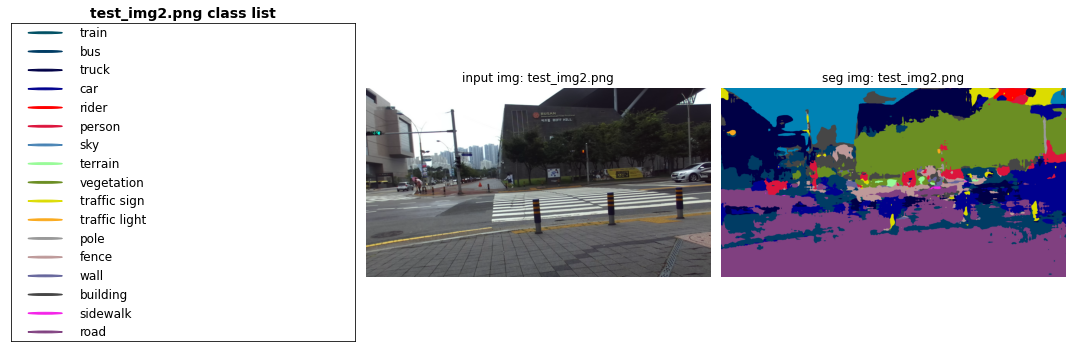

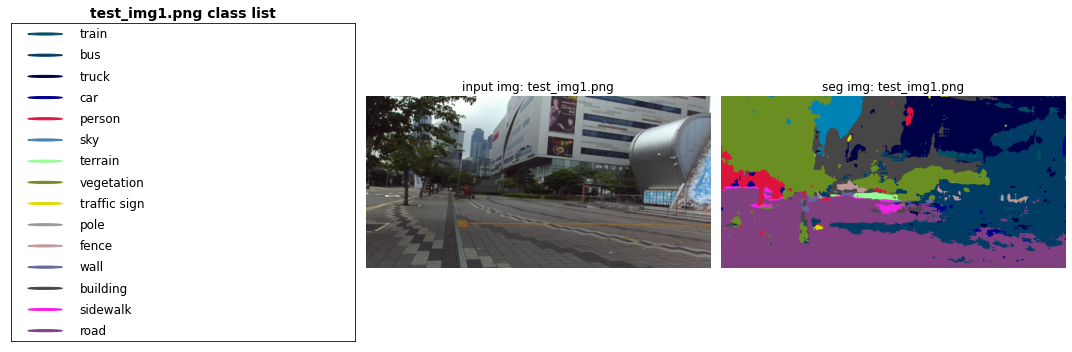

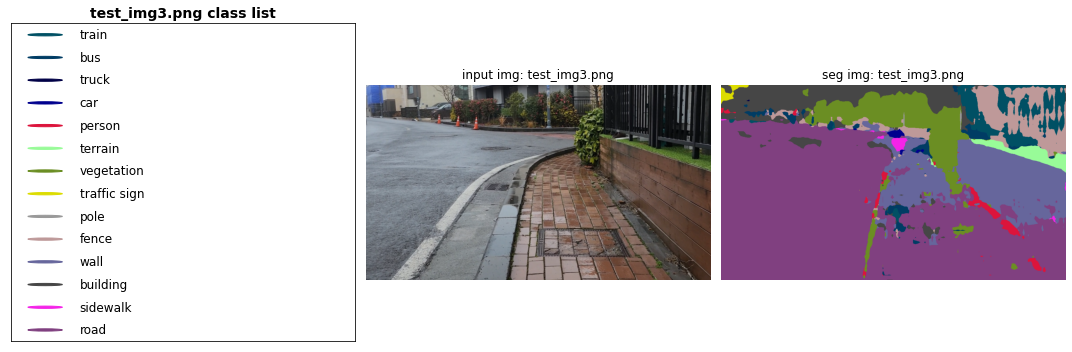

In [5]:
# png 폴더 내 모든 .png 파일 가져오기
image_files = [f for f in os.listdir(input_folder) if f.endswith(".png")]

# 모든 이미지 처리
for image_name in image_files:
    image_path = os.path.join(input_folder, image_name)
    
    # 이미지 로드 및 크기 조정 (32의 배수로 조정)
    image = Image.open(image_path).convert('RGB')
    new_width = (image.width // 32) * 32
    new_height = (image.height // 32) * 32
    image = image.resize((new_width, new_height), Image.BILINEAR)

    # 변환 적용 및 배치 차원 추가
    input_tensor = transform(image).unsqueeze(0).to(device)

    # 세그멘테이션 수행
    with torch.no_grad():
        outputs = model(input_tensor)

    # 가장 높은 확률을 가진 클래스로 변환 (픽셀별 클래스 맵)
    pred = torch.argmax(outputs[0], dim=1).squeeze(0).cpu().data.numpy()

    # 등장한 클래스 찾기
    unique_classes = np.unique(pred)  # 등장한 클래스 인덱스 추출
    detected_classes = [CITYSCAPES_CLASSES[i] for i in unique_classes]  # 클래스 이름 매칭

    # 세그멘테이션 결과를 컬러 마스크로 변환
    segmentation_result = get_color_pallete(pred, "citys")

    # 결과 이미지 저장
    output_path = os.path.join(output_folder, f"seg_{image_name}")
    segmentation_result.save(output_path)

    # 개별 이미지별 결과 출력
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 세로 3개 배치 (클래스, 원본, 세그멘테이션)

    # 등장한 클래스 목록 및 색상 시각화
    axes[0].set_xlim(0, 1)
    axes[0].set_ylim(0, len(detected_classes))
    for i, class_name in enumerate(detected_classes):
        color = np.array(CITYSCAPES_COLORS[class_name]) / 255.0  # RGB → 0~1로 정규화
        axes[0].add_patch(plt.Circle((0.1, len(detected_classes) - i - 0.5), 0.05, color=color))  # 원형 색상
        axes[0].text(0.2, len(detected_classes) - i - 0.5, class_name, va='center', fontsize=12)

    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_title(f"{image_name} class list", fontsize=14, fontweight="bold")
    axes[0].invert_yaxis()  # 위에서 아래로 정렬

    # 원본 이미지 출력
    axes[1].imshow(image)
    axes[1].set_title(f"input img: {image_name}")
    axes[1].axis("off")

    # 세그멘테이션 결과 출력
    axes[2].imshow(segmentation_result)
    axes[2].set_title(f"seg img: {image_name}")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()